In [1]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('../data/player_stats_trends.csv')
tournament_stats = pd.read_csv('../data/tournament_stats.csv')
goals = pd.read_csv('../data/goals.csv')
awards = pd.read_csv('../data/awards.csv')

In [3]:
awards['Year'] = awards['Season'].apply(lambda x: float(str(x)[-2:]))
awards = awards.drop(columns=['Season', 'Club/Country'])
awards = awards.groupby('Award').filter(lambda x: len(x) >= 5)
awards = awards[~awards['Award'].isin(["Winner Ballon d'Or", 'Footballer of the Year', 'UEFA Best Player in Europe', "The Best FIFA Men's Player", 'Player of the Year', 'Top goal scorer', 'African Footballer of the Year', 'TM-Player of the season'])]

awards = pd.get_dummies(awards, columns=['Award'], prefix='', prefix_sep='')

for col in awards.columns:
    if col not in ['Player', 'Year']:
        awards[col] = awards[col].astype(int)
awards = awards.groupby(['Player', 'Year']).sum().reset_index()


In [4]:
def goal_fixer(goals):
    try:
        return int(goals)
    except:
        return 0
def run_model(X, y):
    glm = sm.GLM(endog=y, exog= X, family=sm.families.Gaussian())
    X = sm.add_constant(X)
    glm_results = glm.fit()
    return glm_results
def remove_p(X, glm_results, p):
    to_remove = []
    for i in glm_results.pvalues.index:
        if glm_results.pvalues[i] > p:
            to_remove.append(i)
        elif np.isnan(glm_results.pvalues[i]):
            to_remove.append(i)
    X = X.drop(columns=to_remove)
    return X

In [5]:
tournament_stats['Year'] = tournament_stats['Season'].apply(lambda x: float(x[-2:]))
tournament_stats = tournament_stats.drop('Season', axis=1)
tournament_stats = tournament_stats.query('Year >= 8 & Year <= 23')
tournament_stats['Goals'] = tournament_stats['Goals'].apply(lambda x: goal_fixer(x))
tournament_stats['Minutes played']= tournament_stats['Minutes played'].str.replace("'", '').str.replace('.', '')
for col in tournament_stats.columns:
    if col not in ['Player', 'Competition', 'Club', 'Year']:
        try:
            tournament_stats[col] = tournament_stats[col].str.replace('-', '0').astype(float)
        except:
            pass 

comp_goals = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Goals'].replace(np.nan, 0).reset_index()
comp_goals = comp_goals.rename(columns=lambda x: x + '_Goals')
comp_goals.rename(columns={'Year_Goals': 'Year', 'Player_Goals' : 'Player'}, inplace=True)

comp_ass = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Assists'].replace(np.nan, 0).reset_index()
comp_ass = comp_ass.rename(columns=lambda x: x + '_ass')
comp_ass.rename(columns={'Year_ass': 'Year', 'Player_ass' : 'Player'}, inplace=True)

Goals = []
for i in comp_goals.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_goals['Goals'] = Goals

Goals = []
for i in comp_ass.iterrows():
    rs = 0
    for j in i[1].index:
        if j not in ['Player', 'Year']:
            rs += i[1][j]
    Goals.append(rs)
comp_ass['Assists'] = Goals

# comp_mins = tournament_stats.pivot_table(index=['Year', 'Player'], columns='Competition', aggfunc='sum')['Minutes played'].replace(np.nan, 0).reset_index()
# comp_mins = comp_mins.rename(columns=lambda x: x + '_Minutes')
# comp_mins.rename(columns={'Year_Minutes': 'Year', 'Player_Minutes' : 'Player'}, inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_45812\1659856986.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tournament_stats['Minutes played']= tournament_stats['Minutes played'].str.replace("'", '').str.replace('.', '')


In [6]:
df = df.drop(columns=['P1', 'P2', 'P3', 'P4', 'P5', 'Votes', 'RankPts', 'Percent', 'Voted', 'Season', 'Goals', 'Minutes played', 'Assists'])

In [7]:
for i in df.columns:
    if i  not in ['Player', 'Nationality', 'Club']:
        df[i] = df[i].astype(float)

In [8]:
df = df.merge(comp_goals, on=['Year', 'Player'], how='left')
df = df.merge(awards, on=['Year', 'Player'], how='left')
# df = df.merge(comp_mins, on=['Year', 'Player'], how='left')
df = df.merge(comp_ass, on=['Year', 'Player'], how='left')

dfs = []
for i in range(8, 24):
    scaler = MinMaxScaler()
    if  i == 20:
        continue
    df_temp = df.query('Year == @i')
    df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
    df_temp['Ass_Scaled'] = scaler.fit_transform(df_temp['Assists'].values.reshape(-1, 1))

    dfs.append(df_temp)
df = pd.concat(dfs)

df.fillna(0, inplace=True)
df = df.groupby(['Player', 'Year']).sum().reset_index()

C:\Users\User\AppData\Local\Temp\ipykernel_45812\3089184607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
C:\Users\User\AppData\Local\Temp\ipykernel_45812\3089184607.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Ass_Scaled'] = scaler.fit_transform(df_temp['Assists'].values.reshape(-1, 1))
C:\Users\User\AppData\Local\Temp\ipykernel_45812\3089184607.py:12: SettingWithCopyWarning: 
A value is trying to

C:\Users\User\AppData\Local\Temp\ipykernel_45812\3089184607.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Ass_Scaled'] = scaler.fit_transform(df_temp['Assists'].values.reshape(-1, 1))
C:\Users\User\AppData\Local\Temp\ipykernel_45812\3089184607.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp['Goals_Scaled'] = scaler.fit_transform(df_temp['Goals'].values.reshape(-1, 1))
C:\Users\User\AppData\Local\Temp\ipykernel_45812\3089184607.py:13: SettingWithCopyWarning: 
A value is trying to

In [9]:
df = sm.add_constant(df)

# # Tab out after use
# df = df.query('Share > 0')
# df['Share'] = np.log(df['Share'])

train = df.query('Year < 23')
test = df.query('Year == 23')
train.set_index(['Player', 'Year'], inplace=True)
test.set_index(['Player', 'Year'], inplace=True)

X_train, y_train = train.drop(columns=['Share' , 'Rank', 'Points', 'Month']), train['Share']
X_test, y_test = test.drop(columns=['Share', 'Rank', 'Points', 'Month']), test['Share']

glm = sm.GLM(endog=y_train, exog= X_train, family=sm.families.Gaussian())
glm_results = glm.fit()

In [10]:
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.8)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.65)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.5)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.2)
    glm_results = run_model(X_train, y_train)
for i in range(2):
    X_train = remove_p(X_train, glm_results, 0.05)
    glm_results = run_model(X_train, y_train)

In [11]:
len(set(df['Year']))

15

In [12]:
glm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Share   No. Observations:                  333
Model:                            GLM   Df Residuals:                      323
Model Family:                Gaussian   Df Model:                            9
Link Function:               identity   Scale:                       0.0031008
Method:                          IRLS   Log-Likelihood:                 494.29
Date:                Wed, 03 Jan 2024   Deviance:                       1.0016
Time:                        12:27:26   Pearson chi2:                     1.00
No. Iterations:                     3   Pseudo R-squ. (CS):             0.6962
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -0.0221      0.005     -4.242      0.000      -0.032      -0.012
Goals conceded              0.0041      0.001      3.570      0.000       0.002       0.006
Champions League_Goals      0.0087      0.001      8.192      0.000       0.007       0.011
LaLiga_Goals                0.0026      0.000      6.795      0.000       0.002       0.003
Premier League_Goals        0.0009      0.000      2.055      0.040    4.35e-05       0.002
Supercopa_Goals             0.0410      0.009      4.466      0.000       0.023       0.059
Champions League winner     0.0391      0.008      4.970      0.000       0.024       0.055
European champion           0.0307      0.015      2.069      0.039       0.002       0.060
Olympic medalist            0.0675      0.029      2.365      0.018       0.012       0.123
World Cup winner            0.0468      0.015      3.225      0.001       0.018       0.075
===========================================================================================
"""

In [13]:
X_test = X_test[X_train.columns]

In [14]:
preds = glm_results.predict(X_test)
preds = scaler.fit_transform(preds.values.reshape(-1, 1))
y_test = scaler.fit_transform(y_test.values.reshape(-1, 1))

results = []
for i, j, k in zip(X_test.index, y_test, preds):
    results.append([i[0], j[0], k[0]])
results = pd.DataFrame(results, columns=['Player', 'Actual', 'Predicted'])

In [15]:
results.sort_values('Predicted', ascending=False)

,Player,Actual,Predicted
22,Robert Lewandowski,0.013061,1.000000
4,Erling Haaland,0.386270,0.959437
10,Karim Benzema,0.006531,0.897046
19,Mohamed Salah,0.014017,0.473202
26,Vinícius Júnior,0.053042,0.469045
9,Julián Álvarez,0.030264,0.398393
16,Lionel Messi,1.000000,0.376287
27,Yassine Bounou,0.010831,0.376160
2,Bernardo Silva,0.021663,0.372889
11,Kevin De Bruyne,0.108155,0.341155


In [67]:
df = sm.add_constant(df)
results = []
variables = []
for i in range(1000):
    print(i)
    df2 = df.copy()
    df2 = df2.sample(frac = 1, replace=True, random_state=i) 
    train = df2.query('Year < 23')
    test = df2.query('Year == 23')
    train.set_index(['Player', 'Year'], inplace=True)
    test.set_index(['Player', 'Year'], inplace=True)

    X_train, y_train = train.drop(columns=['Share', 'Rank', 'Points', 'Month']), train['Share']
    X_test, y_test = test.drop(columns=['Share', 'Rank', 'Points', 'Month']), test['Share']

    glm = sm.GLM(endog=y_train, exog= X_train, family=sm.families.Gaussian())
    glm_results = glm.fit()
    for i in range(2):
        X_train = remove_p(X_train, glm_results, 0.8)
        glm_results = run_model(X_train, y_train)
    for i in range(2):
        X_train = remove_p(X_train, glm_results, 0.65)
        glm_results = run_model(X_train, y_train)
    for i in range(2):
        X_train = remove_p(X_train, glm_results, 0.5)
        glm_results = run_model(X_train, y_train)
    for i in range(2):
        X_train = remove_p(X_train, glm_results, 0.2)
        glm_results = run_model(X_train, y_train)
    for i in range(2):
        X_train = remove_p(X_train, glm_results, 0.05)
        glm_results = run_model(X_train, y_train)
    results.append(glm_results.pseudo_rsquared())
    for j in X_train.columns:
        variables.append(j)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

<AxesSubplot:ylabel='Count'>

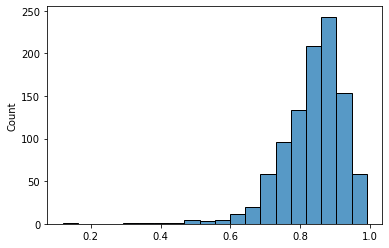

In [68]:
sns.histplot(results, bins=20)

In [70]:
#print(results)
print(variables)

['const', 'Sesond yellow cards', 'Goals conceded', 'Club_World_Cup_appearances', 'UEFA-Cup_Qualifikation_appearances', 'UI_Cup_appearances', 'Europa_League_appearances', 'Trend', 'Champions League_Goals', 'Club World Cup_Goals', 'Copa del Rey_Goals', 'DFB-Pokal_Goals', 'Eredivisie_Goals', 'KNVB beker_Goals', 'Supercopa_Goals', 'Supercoppa Italiana_Goals', 'UEFA-Cup Qualifikation_Goals', 'Copa América winner', 'Dutch champion', 'FIFA Club World Cup winner', 'FIFA Puskás Award', 'French league cup winner', 'German Super Cup winner', 'Italian Super Cup winner', 'Olympic medalist', 'World Cup winner', 'Club World Cup_ass', 'Coupe de la Ligue_ass', 'Eredivisie_ass', 'UEFA-Cup Qualifikation_ass', 'Goals_Scaled', 'const', 'Goals conceded', 'Champions League_Goals', 'LaLiga_Goals', 'Premier League_Goals', 'Serie A_Goals', 'Supercopa_Goals', 'Champions League winner', 'Copa América winner', 'European champion', 'German Super Cup winner', 'Italian champion', 'Spanish Super Cup winner', 'World Cu

In [16]:
from collections import defaultdict

#d =


results_pred = results.sort_values('Predicted', ascending=False)
results_actual = results.sort_values('Actual', ascending=False)


ranked_dict =  defaultdict(list)
for i, j in enumerate(results_actual["Player"].values):
    ranked_dict[j] = [i+1]
    
#print(ranked_dict)    
for m, z in  enumerate(results_pred["Player"].values):
    ranked_dict[z].append(m+1)

d = []  
actual = []
predicted = []
for player, ranks in ranked_dict.items(): 
    diff = ranks[0]-ranks[1]
    d.append(diff)
    actual.append(ranks[0])
    predicted.append(ranks[1])

print(d)
print(actual)
print(predicted)

[-6, 0, -8, -6, -7, 1, 1, -9, 0, -10, 7, 11, 5, 1, -8, 13, -2, 3, -2, 2, -7, 6, -2, -3, -1, 4, 3, 14, 0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
[7, 2, 11, 10, 12, 5, 6, 17, 9, 20, 4, 1, 8, 13, 23, 3, 19, 15, 21, 18, 28, 16, 25, 27, 26, 22, 24, 14, 29]


### WILCONXON Signed rank test

In [17]:
from scipy.stats import wilcoxon
res = wilcoxon(d, alternative='two-sided')
res.statistic, res.pvalue

(167.0, 0.8288547709143317)

### MANN-WHITNEY U-test

In [18]:
from scipy.stats import mannwhitneyu
from scipy.stats import norm
U1, p = mannwhitneyu(actual, predicted, method="exact")

nx, ny = len(actual), len(predicted)
U2 = nx*ny - U1
print(U2)

U = min(U1, U2)
N = nx + ny
z = (U - nx*ny/2 + 0.5) / np.sqrt(nx*ny * (N + 1)/ 12)
p = 2 * norm.cdf(z)  # use CDF to get p-value from smaller statistic
print(p)

420.5
1.0062040074241658


In [19]:
res = mannwhitneyu(actual, predicted, alternative="two-sided", method="exact")
print(res)

MannwhitneyuResult(statistic=420.5, pvalue=1.0)


### SPEARMAN'S rank correlation Test

In [20]:
from scipy.stats import spearmanr

coef, p = spearmanr(actual, predicted)
print('Spearmans correlation coefficient: %.3f' % coef)

Spearmans correlation coefficient: 0.720


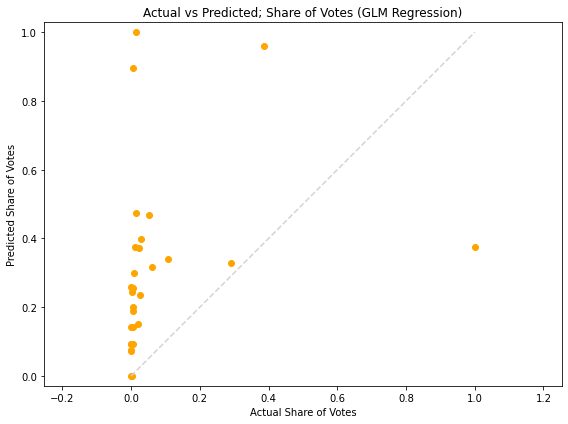

In [46]:
# Plotting the differences using a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(results['Actual'], results['Predicted'], color='orange')
plt.plot([0, 1], [0, 1], linestyle='--', color='lightgray')  # Diagonal line for reference
plt.xlabel('Actual Share of Votes')
plt.ylabel('Predicted Share of Votes')
plt.title('Actual vs Predicted; Share of Votes Relatively to the Winner (GLM Regression)')
plt.axis('equal')  # Set equal scaling for both axes
plt.tight_layout()
plt.show()

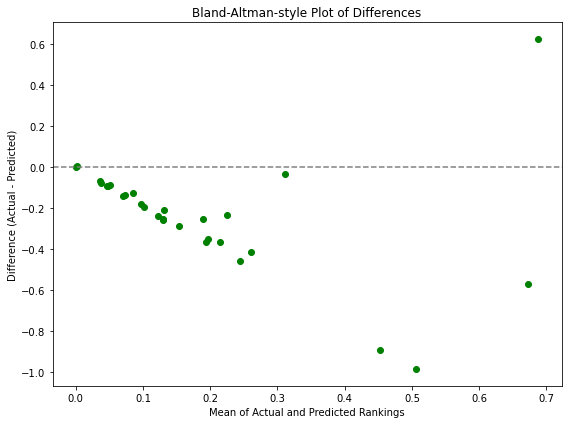

In [27]:
# Calculate the differences between actual and predicted rankings
differences = results['Actual'] - results['Predicted']
means = (results['Actual'] + results['Predicted']) / 2

# Plotting a Bland-Altman style plot for the differences
plt.figure(figsize=(8, 6))
plt.scatter(means, differences, color='green')
plt.axhline(y=0, color='gray', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Mean of Actual and Predicted Rankings')
plt.ylabel('Difference (Actual - Predicted)')
plt.title('Bland-Altman-style Plot of Differences')
plt.tight_layout()
plt.show()

In [57]:
last_names = []
for i in list(results["Player"].values): 
    last_names.append(i.split(' ')[-1])
print(last_names)

['Onana', 'Griezmann', 'Silva', 'Saka', 'Haaland', 'Kane', 'Musiala', 'Gvardiol', 'Bellingham', 'Álvarez', 'Benzema', 'Bruyne', 'Kvaratskhelia', 'Min-jae', 'Mbappé', 'Martínez', 'Messi', 'Modrić', 'Ødegaard', 'Salah', 'Barella', 'Muani', 'Lewandowski', 'Rodri', 'Dias', 'Osimhen', 'Júnior', 'Bounou', 'Gündoğan']


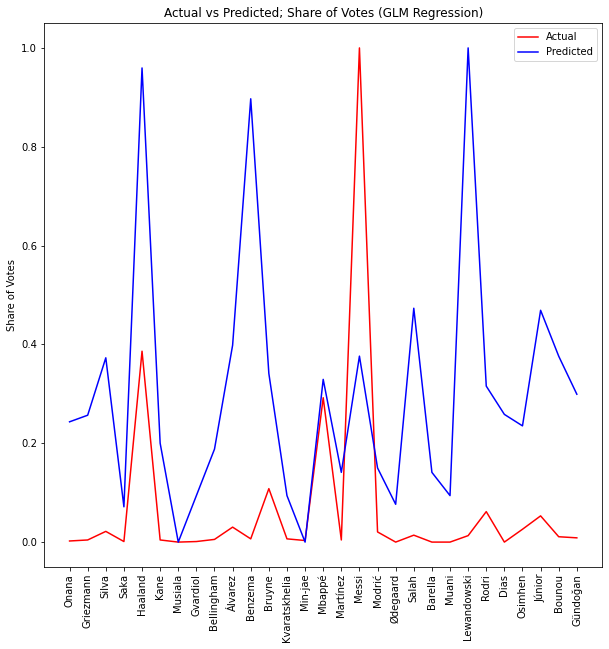

In [63]:
plt.figure(figsize = (10,10))

plt.plot(results["Actual"], color = "red", label = "Actual")
plt.plot(results["Predicted"], color ="blue", label = "Predicted")
plt.title("Actual vs Predicted; Share of Votes relative to the Winner (GLM Regression)")
plt.ylabel("Share of Votes")
#plt.xlabel("Player Indexes")
plt.xticks(np.arange(0, len(last_names)), last_names, rotation = 90)
plt.legend()
plt.show()



In [21]:
# df[['Player', 'Year','Share']].to_csv('../data/graphs/share.csv', index=False)

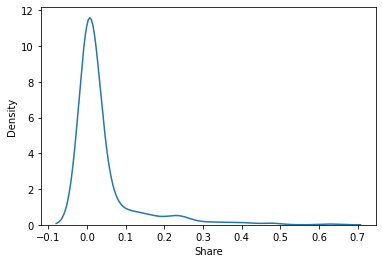

In [64]:
sns.kdeplot(df['Share'])
plt.show()

In [23]:
from matplotlib import style
style.use('seaborn-v0_8-bright')

OSError: 'seaborn-v0_8-bright' not found in the style library and input is not a valid URL or path; see `style.available` for list of available styles

In [ ]:
style.available